# Data Analysis

In [1]:
from __future__ import division, print_function
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt
import collections
import nltk
import numpy as np
import os
import logging
%matplotlib inline

In [2]:
DATA_DIR = "../data"

VOCAB_FILE = os.path.join(DATA_DIR, "ng-vocab.tsv")

logging.basicConfig()

## Data Loading

We make use of built in downloader available in Scikit-Learn to download the 20 newsgroup dataset from [http://people.csail.mit.edu/jrennie/20Newsgroups/20news-bydate.tar.gz](http://people.csail.mit.edu/jrennie/20Newsgroups/20news-bydate.tar.gz) and make it available in an in-memory data structure.

In [3]:
ng_data = fetch_20newsgroups(subset='all',
                             data_home=DATA_DIR,
                             shuffle=True, 
                             random_state=42)
num_docs = len(ng_data.data)
print(num_docs)

18846


In [4]:
texts = ng_data.data
y = np.array(ng_data.target)
id2labels = {x[0]:x[1] for x in enumerate(ng_data.target_names)}

## Vocabulary

In [5]:
counter = collections.Counter()
for text in ng_data.data:
    for sent in nltk.sent_tokenize(text):
        sent = sent.encode("utf8").decode("ascii", "ignore").lower()
        for word in nltk.word_tokenize(sent):
            counter[word] += 1

fvocab = open(VOCAB_FILE, "wb")
for word, count in counter.most_common():
    fvocab.write("{:s}\t{:d}\n".format(word, count))
fvocab.close()

In [6]:
vocab_size = len([w for w, c in counter.most_common() if c >= 5])
print(vocab_size)

46655


## Compute #-sentences per document

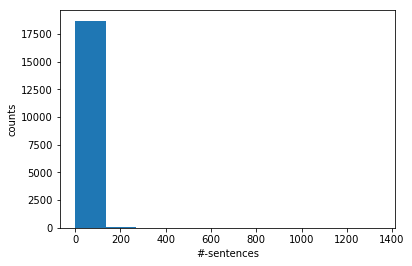

In [7]:
num_sents = np.zeros(num_docs)
for i, text in enumerate(ng_data.data):
    for sent in nltk.sent_tokenize(text):
        num_sents[i] += 1

plt.hist(num_sents, bins=10)
plt.xlabel("#-sentences")
plt.ylabel("counts")
plt.show()

In [8]:
for i in range(90, 100):
    print("{:d} percentile, #-sentences: {:.0f}".format(
        i, np.percentile(num_sents, i)))

90 percentile, #-sentences: 28
91 percentile, #-sentences: 30
92 percentile, #-sentences: 32
93 percentile, #-sentences: 35
94 percentile, #-sentences: 38
95 percentile, #-sentences: 43
96 percentile, #-sentences: 49
97 percentile, #-sentences: 58
98 percentile, #-sentences: 75
99 percentile, #-sentences: 113


## Compute #-words per sentence

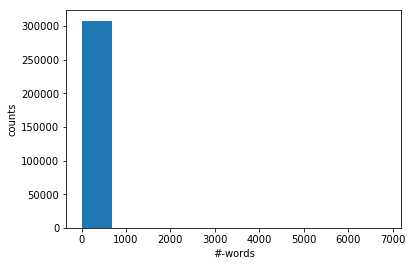

In [9]:
num_words = []
for i, text in enumerate(ng_data.data):
    for sent in nltk.sent_tokenize(text):
        num_words_in_sent = 0
        for word in nltk.word_tokenize(sent):
            num_words_in_sent += 1
        num_words.append(num_words_in_sent)

plt.hist(num_words, bins=10)
plt.xlabel("#-words")
plt.ylabel("counts")
plt.show()

In [10]:
num_words = np.array(num_words)
for i in range(90, 100):
    print("{:d} percentile, #-sentences: {:.0f}".format(
        i, np.percentile(num_words, i)))

90 percentile, #-sentences: 47
91 percentile, #-sentences: 49
92 percentile, #-sentences: 52
93 percentile, #-sentences: 56
94 percentile, #-sentences: 60
95 percentile, #-sentences: 64
96 percentile, #-sentences: 70
97 percentile, #-sentences: 79
98 percentile, #-sentences: 91
99 percentile, #-sentences: 118
